In [1]:
from PIL import Image
import zipfile
import xml.etree.ElementTree as ET
from io import BytesIO
from tqdm import tqdm

import cv2
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## Create a food dictionnary to match the category number to the food brand
food_dict = {}

zip_file_path = '../../Datasets/FoodLogoDet-1500.zip'
text_file_name = 'FoodLogoDet-1500/food.txt'

with zipfile.ZipFile(zip_file_path, 'r') as z:
    with z.open(text_file_name) as file:
        for line in file:
            line = line.strip()
            line = line.decode('utf-8').strip()
            if line:  # Check if the line is not empty
                value, key = line.split(':')
                food_dict[key] = value

print(list(food_dict.keys())[0], ':', list(food_dict.values())[0])
print(len(food_dict))

1 : 10 Cane
1500


In [3]:
## Create a pandas dataset to do the EDA
zip_file_path = '../../Datasets/FoodLogoDet-1500.zip'
annotation_folder = 'FoodLogoDet-1500/Annotations/'

data = []

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as z:
    # List all files in the zip
    files_in_zip = z.namelist()
    
    # Filter for XML files in the annotation folder
    annotation_files = [f for f in files_in_zip if f.startswith(annotation_folder) and f.endswith('.xml')]
    
    # Iterate over each XML file
    for xml_file in annotation_files:
        with z.open(xml_file) as file:
            xml_content = file.read()
            root = ET.fromstring(xml_content)

            image_name = xml_file.split('/')[-1].split('.')[0]
            ## for the last elements of the folder the following code line doesn't give the right name associated with
            ## the image.
            # image_name = root.find('filename').text.replace(".jpg", "") 

            nb_object = len(root.findall('object'))
            folder = root.find('folder').text
            # Extract the category (object name)
            for obj in root.findall('object'):
                category = obj.find('name').text 
                trunc = obj.find('truncated').text
                # Store filename and category
                data.append({'filename': image_name, 
                             'folder': folder, #This category might be useless
                             'num_objects': nb_object,
                             'category': food_dict[category], 
                             'truncated': trunc})
df = pd.DataFrame(data)

# Function to extract the base brand name
def extract_brand(category):
    if pd.isna(category):
        return None
    # Use regex to match 'brand names' followed by optional '-number'
    match = pd.Series(category).str.extract(r'^(.*?)(?:-\d+)?$')
    return match[0].iloc[0] if not match.empty else category

df['brand'] = df['category'].apply(extract_brand)
print('number of product:', len(df))

df.head()


number of product: 145400


,filename,folder,num_objects,category,truncated,brand
0,000001,Arizmendi Bakery,1,Arizmendi Bakery,0,Arizmendi Bakery
1,000002,VOC2007,2,Anglo Bubbly,0,Anglo Bubbly
2,000002,VOC2007,2,Anglo Bubbly,0,Anglo Bubbly
3,000003,VOC2007,1,toblerone,0,toblerone
4,000004,VOC2007,2,vikingfjord,0,vikingfjord


In [4]:
'''After Having a look at the pictures and the names of the brands associated, I noted that there are 4 pictures
where there are apparently 2 brands on the picture where actually I only see one. So I decided to remove from the dataset
the row with the other brand that I don't see.'''
def remove_unwanted_discepancies(df):
    # Step 1: Identify discrepancies
    discrepancies = df.groupby('filename')['brand'].nunique()
    filenames_with_discrepancies = discrepancies[discrepancies > 1].index.tolist()
    if filenames_with_discrepancies:
        for filename in filenames_with_discrepancies:
            brands = df[df['filename'] == filename]['brand'].unique()
            print(f"Filename: {filename} has the following brands: {brands}")

    # Step 2: Create a DataFrame with rows from the original DataFrame that have these filenames
    discrepancy_rows = df[df['filename'].isin(filenames_with_discrepancies)]

    # Step 3: Keep only the rows where brand is 'Buddy Fruits' instead of 'Boon Rawd Brewery'
    buddy_fruit_rows = discrepancy_rows[discrepancy_rows['brand'] == 'Buddy Fruits']

    # Step 4: Combine with the rest of the original DataFrame (keeping only unique filenames)
    remaining_rows = df[~df['filename'].isin(filenames_with_discrepancies)]
    final_df = pd.concat([remaining_rows, buddy_fruit_rows]).reset_index(drop=True)
    return final_df

print(f"Total rows in the original DataFrame: {len(df)}")
df = remove_unwanted_discepancies(df)
print(f"Total rows in the final DataFrame: {len(df)}")
print(df[df['filename'] == '070411'])

Total rows in the original DataFrame: 145400
Filename: 070410 has the following brands: ['Boon Rawd Brewery' 'Buddy Fruits']
Filename: 078389 has the following brands: ['Buddy Fruits' 'Boon Rawd Brewery']
Filename: 080601 has the following brands: ['Boon Rawd Brewery' 'Buddy Fruits']
Filename: 086755 has the following brands: ['Buddy Fruits' 'Boon Rawd Brewery']
Total rows in the final DataFrame: 145396
       filename      folder  num_objects    category truncated       brand
102726   070411  Qianheshou            2  Qianheshou         0  Qianheshou
102727   070411  Qianheshou            2  Qianheshou         0  Qianheshou


In [5]:
## Create a numpy array with all images which have 3 dimension :  (height, width, RGB)
zip_file_path = '../../Datasets/FoodLogoDet-1500.zip'
image_folder = 'FoodLogoDet-1500/JPEGImages/'


image_list = []

with zipfile.ZipFile(zip_file_path, 'r') as z:
    files_in_zip = z.namelist()
    image_files = [f for f in files_in_zip if f.startswith(image_folder) and f.endswith('.jpg')][:10000]
    
    image_list = [0]*len(image_files)
    i = 0
    for img_file in tqdm(image_files, desc="Processing images"):
        try:
            with z.open(img_file) as img_data:
                img = Image.open(BytesIO(img_data.read()))
                img_array = np.array(img.convert('RGB'))
                image_list[i] = img_array
        except OSError as e:
            # Print a warning message if the image is corrupted or truncated
            print(f"Warning: Could not process image {img_file}. Error: {e}")
        i +=1

images_array = np.array(image_list, dtype=object)
print(images_array[1].shape)
print("Shape of the array containing all images:", images_array.shape)



Processing images: 100%|██████████| 10000/10000 [02:38<00:00, 63.18it/s]

(362, 519, 3)
Shape of the array containing all images: (10000,)


Min and max for dimension 1: 45 6285 Average value: 443.2446
Min and max for dimension 2: 70 5760 Average value: 496.1512


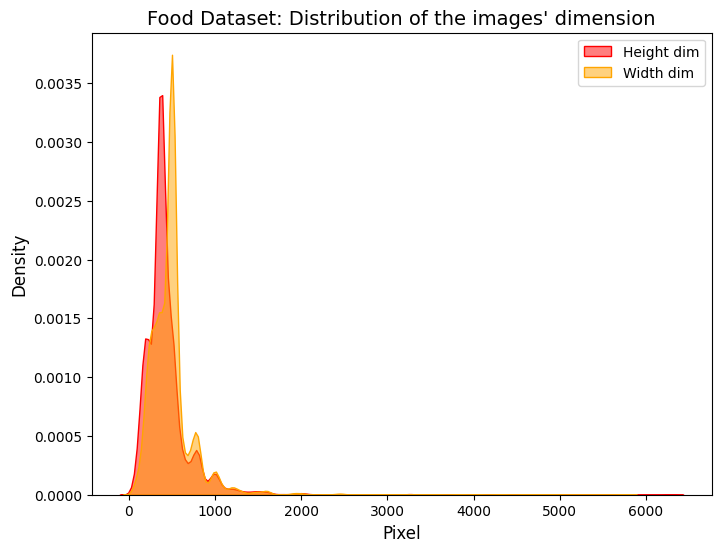

In [10]:
## Plot the distribution of the dimension of our images to know how to resize them

dim_1 = []
dim_2 = []

for k in images_array:
    shape_1, shape_2, shape_3 = k.shape
    dim_1.append(shape_1)
    dim_2.append(shape_2)

print('Min and max for dimension 1:', min(dim_1), max(dim_1), 'Average value:', sum(dim_1)/len(dim_1))
print('Min and max for dimension 2:', min(dim_2), max(dim_2), 'Average value:', sum(dim_2)/len(dim_2))

plt.figure(figsize=(8, 6))
sns.kdeplot(dim_1, label='Height dim', fill=True, color='red', alpha=0.5)
sns.kdeplot(dim_2, label='Width dim', fill=True, color='orange', alpha=0.5)
plt.title("Food Dataset: Distribution of the images' dimension", fontsize=14)
plt.xlabel('Pixel', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.show()

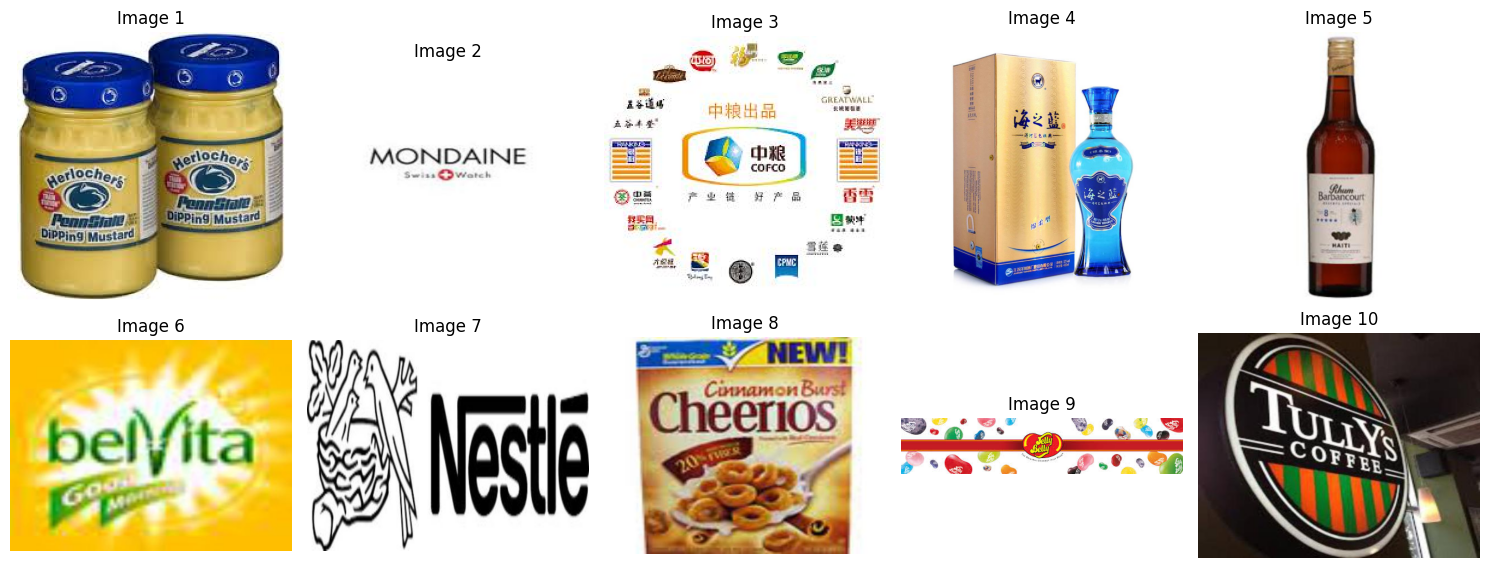

In [14]:

fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns
axes = axes.flatten()  # Flatten the axes for easy iteration

# Step 4: Load and display each random image in a subplot
for i, (image,ax) in enumerate(zip(images_array[5:15],axes)):
    # if image:
    ax.imshow(image)
    ax.set_title(f"Image {i+1}")
    ax.axis('off')  # Hide axes for cleaner display
    # else:
    #     ax.text(0.5, 0.5, 'Failed to load image', fontsize=12, ha='center', va='center')
    #     ax.axis('off')

# Adjust layout and display the figure
plt.tight_layout()
plt.show()

In [59]:
## Resize all the pictures in the data to the specify target size
# (This parameter could be changed later during the project to yield better results)

def resize_with_padding(image, target_size=(512, 512)):
    old_size = image.shape[:2]  # old_size is in (height, width) format
    ratio = float(target_size[0]) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])

    # Resize the image
    image = cv2.resize(image, (new_size[1], new_size[0]))

    # Padding to match target size
    delta_w = target_size[1] - new_size[1]
    delta_h = target_size[0] - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    color = [0, 0, 0]  # Padding color (black)
    new_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return new_image

resized_images = [0]* len(images_array)
i = 0
for im in tqdm(images_array):
    resized_images[i] = resize_with_padding(im)
    i+=1
resized_images = np.array(resized_images)
print(resized_images.shape)

100%|██████████| 10000/10000 [00:05<00:00, 1966.01it/s]


0    Arizmendi Bakery
Name: brand, dtype: object


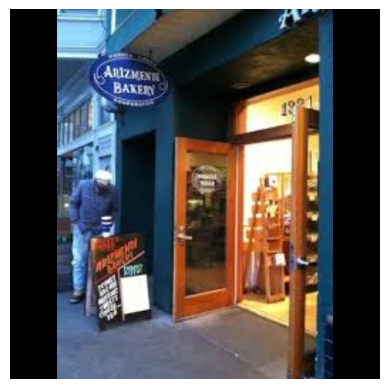

In [154]:
## Verify that the brand corresponds to the picture
idx = 1
formatted_number = str(idx).zfill(6)
print(df[df['filename'] == formatted_number]['brand'])

plt.imshow(resized_images[idx-1]) # idx - 1 to access the correct image cause numpy are zero-indexed
plt.axis('off')
plt.show()

In [159]:
unique_rows = df.drop_duplicates(subset='filename')
annotations = unique_rows.head(10000)
print(len(annotations))
annotations['brand'].nunique()

10000


1367

Model CNN

In [161]:
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [165]:
# Assuming 'images' is a NumPy array of shape (num_samples, 512, 512, 3)
# and 'df' is your DataFrame

# Get unique brands and create a mapping to integers
unique_brands = annotations['brand'].unique()
brand_to_index = {brand: idx for idx, brand in enumerate(unique_brands)}

# Create labels for each image based on the DataFrame
labels = annotations['brand'].map(brand_to_index).values

# One-hot encode the labels
labels = to_categorical(labels, num_classes=len(unique_brands))

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(resized_images, labels, test_size=0.2, random_state=42)
print('TrainX size', len(X_train), '& Val X size', len(X_val))

In [171]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(len(unique_brands), activation='softmax'))  # Output layer for multi-class classification

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [172]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
250/250 [==============================] - 3378s 13s/step - loss: 9.4385 - accuracy: 0.0109 - val_loss: 7.1190 - val_accuracy: 0.0035
Epoch 2/20
250/250 [==============================] - 1289s 5s/step - loss: 6.9675 - accuracy: 0.0132 - val_loss: 7.0429 - val_accuracy: 0.0090
Epoch 3/20
250/250 [==============================] - 1832s 7s/step - loss: 6.5480 - accuracy: 0.0342 - val_loss: 7.1829 - val_accuracy: 0.0135
Epoch 4/20
250/250 [==============================] - 1950s 8s/step - loss: 5.8803 - accuracy: 0.0911 - val_loss: 7.8376 - val_accuracy: 0.0160
Epoch 5/20
250/250 [==============================] - 12565s 50s/step - loss: 5.2555 - accuracy: 0.1615 - val_loss: 8.8184 - val_accuracy: 0.0185
Epoch 6/20
250/250 [==============================] - 39004s 157s/step - loss: 4.7500 - accuracy: 0.2268 - val_loss: 11.1978 - val_accuracy: 0.0210
Epoch 7/20
115/250 [============>.................] - ETA: 19:34 - loss: 4.3410 - accuracy: 0.2894

KeyboardInterrupt: 

In [ ]:
# Extract accuracy values
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()
